# Air-Side Economizer Cycle

In [1]:
import numpy as np
from hvac import Quantity
from hvac.fluids import HumidAir
from hvac.air_conditioning import (
    AdiabaticMixing, AirStream,
    AirConditioningProcess
)
from hvac.charts import LineChart

Q_ = Quantity

*This example is taken from the book "Heating and Cooling of Buildings" by T. Agami Reddy, Jan F. Kreider, Peter S. Curtiss and Ari Rabl (3rd Edition, 2017), Chapter 19: Example 19.11* 

At the entrance of the AHU outdoor air is mixed with return air from the space. There are conditions that we could get at the required supply air temperature just by mixing the right amount of outdoor air with return air in the mixing chamber, so that we don't need to activate the cooling coil, and as such, we can save energy.

Suppose that the required supply air temperature is fixed. The desired space air condition is also fixed. We want to determine what fraction of outdoor airflow we need at the mixing chamber to retrieve the required supply air temperature for a given range of outdoor air temperatures.

**Fixed supply air temperature**

In [2]:
T_sup = Q_(13.0, 'degC')
AS_sup = AirStream(Tdb=T_sup)

**Fixed space air condition**

In [3]:
T_ret, RH_ret = Q_(24.0, 'degC'), Q_(50.0, 'pct')
AS_ret = AirStream(state=HumidAir(Tdb=T_ret, RH=RH_ret))

**Range of outdoor air temperatures**

In [4]:
T_out_range = Q_(np.arange(-10.0, 36.0, 0.1), 'degC')

Consider the outdoor air relative humidity to be constant (which means that as the outdoor air temperature increases, the absolute humidity will also increase).

In [5]:
RH_out = Q_(70, 'pct')

The outdoor air mass flow rate can never be greater than the supply air mass flow rate that leaves the mixing chamber. Also, a minimum amount of outdoor air must always be present for space ventilation.

In [6]:
frac_m_dot_out_min, frac_m_dot_out_max  = Q_(0.25, 'frac'), Q_(1.0, 'frac')

Now, we can determine the required fraction of outdoor airflow to get at the required supply air temperature for the given range of outdoor air temperatures:

In [7]:
frac_m_dot_out_rng = Q_(np.zeros(len(T_out_range)), 'frac')

for i, T_out in enumerate(T_out_range):
    AS_out = AirStream(state=HumidAir(Tdb=T_out, RH=RH_out))
    mix = AdiabaticMixing(
        in1=AS_out,
        in2=AS_ret,
        out=AS_sup
    )
    frac_m_dot_out = mix.m_da_i1_fractional
    if frac_m_dot_out < frac_m_dot_out_min:
        frac_m_dot_out = frac_m_dot_out_min
    if frac_m_dot_out > frac_m_dot_out_max:
        frac_m_dot_out = frac_m_dot_out_max
    frac_m_dot_out_rng[i] = frac_m_dot_out

Let's show the results in a diagram:

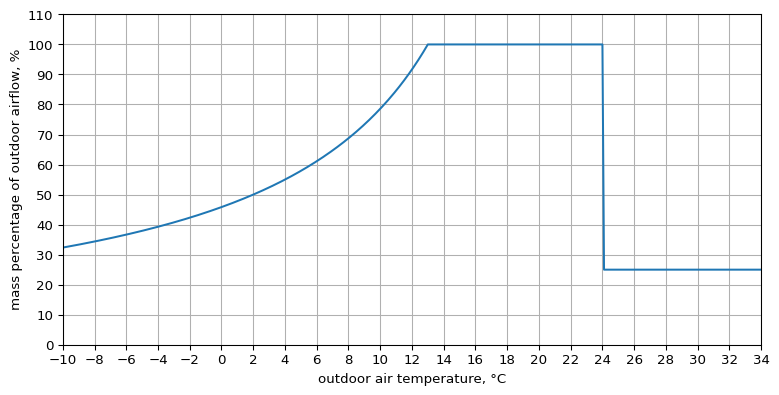

In [8]:
diagram = LineChart(size=(8, 4), dpi=96)
diagram.add_xy_data(
    label='percentage of outdoor airflow required',
    x1_values=T_out_range.to('degC').magnitude,
    y1_values=frac_m_dot_out_rng.to('pct').magnitude
)
diagram.x1.scale(
    lower_limit=T_out_range[0].to('degC').m, 
    upper_limit=T_out_range[-1].to('degC').m, 
    step=2)
diagram.y1.scale(
    lower_limit=0, 
    upper_limit=120, 
    step=10
)
diagram.x1.add_title('outdoor air temperature, °C')
diagram.y1.add_title('mass percentage of outdoor airflow, %')
diagram.show()

When outdoor air temperature is low, only a small fraction of outdoor airflow is needed to be mixed with return air to get at the required supply air temperature. As outdoor air temperature rises and comes closer to the required supply air temperature, a greater fraction of outdoor airflow becomes needed. At the point where outdoor air temperature is equal to the required supply air temperature, the fraction of outdoor airflow becomes 100 %, and there is no mixing with return air anymore: all supply air to the room is now coming from outdoors. From then on, the mixed air temperature will raise above the required supply air temperature and mechanical cooling becomes necessary. When outdoor air temperature just exceeds return air temperature, the theoretically required fraction of outdoor air suddenly falls from positive down to negative infinity. From then on, hot airflow from outdoors is limited to what is only required for ventilation of the room.  

With the calculated fraction of outdoor airflow determined, and knowing the outdoor and return air condition, the resulting mixed air condition can be determined: 

In [9]:
T_mix_range = Q_(np.zeros(len(T_out_range)), 'K')
W_mix_range = Q_(np.zeros(len(T_out_range)), 'kg / kg')
i = 0
for frac_m_dot_out, T_out in zip(frac_m_dot_out_rng, T_out_range):
    mix = AdiabaticMixing(
        in1=AirStream(
            state=HumidAir(Tdb=T_out, RH=RH_out), 
            m_da_fractional=frac_m_dot_out
        ),
        in2=AS_ret
    )
    AS_mix = mix.stream_out
    T_mix_range[i] = AS_mix.state.Tdb
    W_mix_range[i] = AS_mix.state.W
    i += 1

The diagram below shows how mixed air temperature changes with outdoor air temperature using the fraction of outdoor airflow that was calculated as a function of outdoor air temperature.

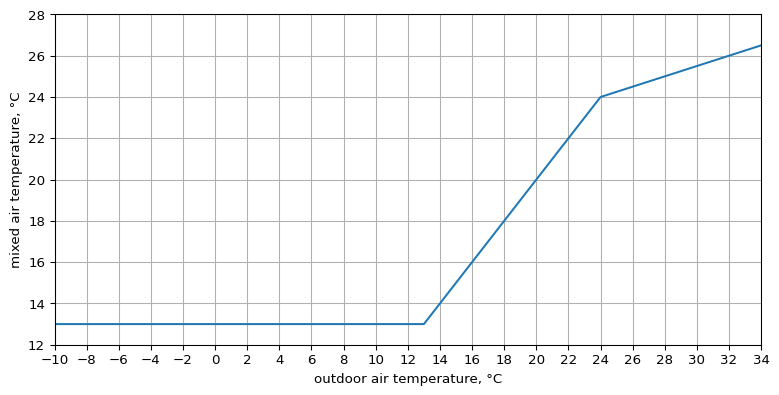

In [10]:
diagram = LineChart(size=(8, 4), dpi=96)
diagram.add_xy_data(
    label='mixed air temperature',
    x1_values=T_out_range.to('degC').magnitude,
    y1_values=T_mix_range.to('degC').magnitude
)
diagram.x1.scale(
    lower_limit=T_out_range[0].to('degC').m, 
    upper_limit=T_out_range[-1].to('degC').m, 
    step=2
)
T_mix_min = min(T_mix_range) - Q_(1, 'K')
T_mix_max = max(T_mix_range) + Q_(1, 'K')
diagram.y1.scale(
    lower_limit=T_mix_min.to('degC').m, 
    upper_limit=T_mix_max.to('degC').m + 2, 
    step=2)
diagram.x1.add_title('outdoor air temperature, °C')
diagram.y1.add_title('mixed air temperature, °C')
diagram.show()

Finally, with the known mixed air condition entering the cooling coil, and the known supply air temperature at the cooling coil outlet, the sensible cooling coil load can also be determined as a function of outdoor air temperature:

In [13]:
Q_sen_range = Q_(np.zeros(len(T_out_range)), 'W')
i = 0
for T_mix, W_mix in zip(T_mix_range, W_mix_range):
    cooling_coil = AirConditioningProcess(
        air_in=HumidAir(Tdb=T_mix, W=W_mix),
        T_ao=T_sup,
        m_da=Q_(1.0, 'kg / s'),
    )
    Q_sen_range[i] = cooling_coil.Q_sen
    i += 1

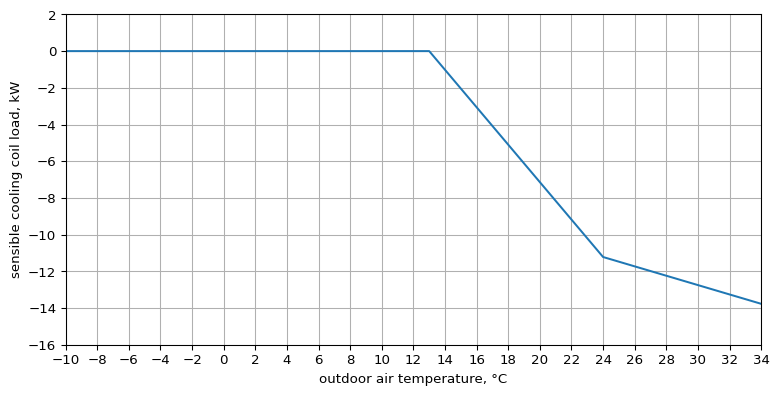

In [14]:
diagram = LineChart(size=(8, 4), dpi=96)
diagram.add_xy_data(
    label='sensible cooling coil load',
    x1_values=T_out_range.to('degC').magnitude,
    y1_values=Q_sen_range.to('kW').magnitude
)
diagram.x1.scale(
    lower_limit=T_out_range[0].to('degC').m, 
    upper_limit=T_out_range[-1].to('degC').m, 
    step=2
)
Q_sen_min = round(min(Q_sen_range).to('kW').m) - 2
Q_sen_max = round(max(Q_sen_range).to('kW').m) + 4
diagram.y1.scale(
    lower_limit=Q_sen_min, 
    upper_limit=Q_sen_max, 
    step=2
)
diagram.x1.add_title('outdoor air temperature, °C')
diagram.y1.add_title('sensible cooling coil load, kW')
diagram.show()